# EDA and Preprocessing

## Table of Contents
- [Importing Necessary Libraries & Loading Data](#Importing-Necessary-Libraries-&-Loading-Dsta)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Settlement Price](#Settlement-Price)
    - [Exogenous Features](#Exogenous-Features)
- [Preprocessing](#Preprocessing)
    - [Settlement Price](#Settlement-Price)
    - [Exogenous Features](#Exogenous-Features)

## Importing Necessary Libraries & Loading Data

In [61]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from datetime import datetime

import seaborn as sns
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from warnings import catch_warnings
from warnings import filterwarnings
import warnings

warnings.simplefilter(action="ignore")

In [62]:
data = pd.read_csv('../Data/Data_concat.csv')
data.head()

,DATE,IA_PRCP,IL_PRCP,MN_PRCP,TMAX_IA,TMAX_IL,TMAX_MN,TMIN_IA,TMIN_IL,TMIN_MN,Settlement Price
0,1990-01-02,0.00,0.00,0.0,49.0,45.0,27.0,28.0,25.0,1.0,5.613
1,1990-01-03,0.00,0.00,0.0,45.0,49.0,32.0,35.0,32.0,19.0,5.673
2,1990-01-04,0.94,0.05,0.0,42.0,47.0,26.0,21.0,32.0,1.0,5.633
3,1990-01-05,0.00,0.00,0.0,40.0,38.0,20.0,18.0,16.0,11.0,5.645
4,1990-01-08,0.00,0.00,0.0,43.0,50.0,40.0,31.0,21.0,16.0,5.707


In [63]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data.sort_index(inplace=True)
data.tail()

,IA_PRCP,IL_PRCP,MN_PRCP,TMAX_IA,TMAX_IL,TMAX_MN,TMIN_IA,TMIN_IL,TMIN_MN,Settlement Price
DATE,,,,,,,,,,
2019-12-24,0.0,0.00,0.00,53.0,57.0,32.0,27.0,26.0,22.0,9.365
2019-12-26,0.0,0.01,0.01,62.0,68.0,33.0,32.0,46.0,22.0,9.465
2019-12-27,0.0,0.00,0.02,37.0,48.0,25.0,32.0,39.0,20.0,9.415
2019-12-30,0.0,0.00,0.38,48.0,42.0,33.0,28.0,35.0,16.0,9.525
2019-12-31,0.0,0.00,0.00,41.0,42.0,18.0,29.0,35.0,9.0,9.555


## Exploratory Data Analysis

Generating descriptive statistics for our data.

In [21]:
data.describe()

,IA_PRCP,IL_PRCP,MN_PRCP,TMAX_IA,TMAX_IL,TMAX_MN,TMIN_IA,TMIN_IL,TMIN_MN,Settlement Price
count,7559.000000,7559.000000,7559.000000,7559.000000,7559.000000,7559.000000,7559.000000,7559.000000,7559.000000,7559.000000
mean,0.099735,0.120437,0.073514,59.598756,68.813732,52.609737,39.699167,46.267231,32.680513,8.151505
std,0.302506,0.347238,0.251940,22.585394,19.677143,24.987382,20.625807,17.902481,22.921733,2.956745
min,0.000000,0.000000,0.000000,-8.000000,0.000000,-21.000000,-27.000000,-14.000000,-35.000000,4.100000
25%,0.000000,0.000000,0.000000,42.000000,54.000000,33.000000,25.000000,32.000000,17.000000,5.727000
50%,0.000000,0.000000,0.000000,63.000000,72.000000,56.000000,41.000000,48.000000,34.000000,7.265000
75%,0.020000,0.030000,0.020000,79.000000,85.000000,75.000000,57.000000,62.000000,53.000000,9.847000
max,5.160000,4.580000,5.600000,105.000000,106.000000,99.000000,80.000000,89.000000,76.000000,17.683000


### Settlement Price
Lets take a closer look at the distribution of the average daily price of soybeans, also known as the 'Settlement Price.'

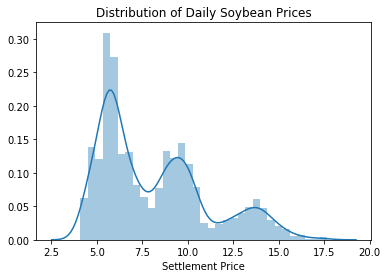

In [31]:
sns.distplot(data['Settlement Price'])
plt.title('Distribution of Daily Soybean Prices');

The distribution of the Settlement Price is trimodal, with approximately half the data located in the first peak since the median = 7.265.  To understand the reason for this distribution, lets look at how the price of soybeans changes over time by plotting a line plot.

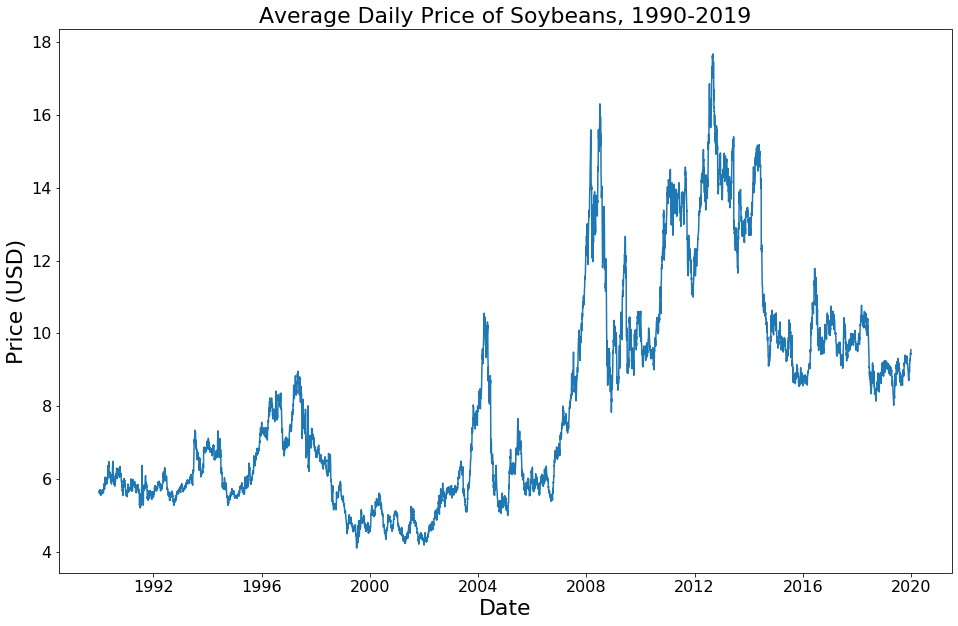

In [29]:
# Set figure size
plt.figure(figsize=(16,10))

# Create Line Plot
plt.plot(data['Settlement Price'])

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Price (USD)', fontsize=22)
plt.title('Average Daily Price of Soybeans, 1990-2019', fontsize=22);

Plotting the seasonal decomposition of the price to understand how much of these fluctuations can be explained by a trend or seasonality, and how much are seamingly random.

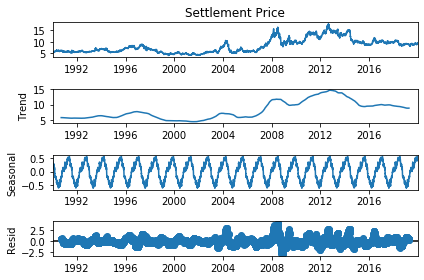

In [74]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(data['Settlement Price'], period = 360)

# Plot the decomposed time series.
decomp.plot()
plt.savefig('../Images/SeasonalDecomp.png');

From the seasonal decomposition, we see the following:
- Trend: there appears to be an upwards trend in the data, and therefore, we might want to incorporate an autoregressive component in our model to capture this.
- Seasonal: there is definite seasonality in the data, causing prices to fluctuate by 0.5 over the course of a year.  Because of this, we may want to include seasonality paramaters in our model.
- Resid: there is randomness in the data.  Because the price is susceptible to random "shocks" our model will benefit from the inclusion of a moving average component to smooth out these shocks.

### Exogenous Features

With a median less than the mean, we know that the precipitation data for each of the three states has a positive skew.  Lets look at the precipitation over time in these states.

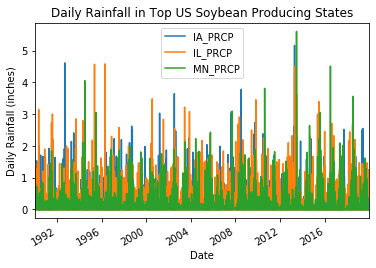

In [10]:
data.drop(columns = ['TMAX_IA', 'TMAX_IL', 'TMAX_MN',
       'TMIN_IA', 'TMIN_IL', 'TMIN_MN', 'Settlement Price']).plot() 
plt.xlabel('Date')
plt.ylabel('Daily Rainfall (inches)')
plt.title('Daily Rainfall in Top US Soybean Producing States');

Comparing the min/ max temperatures in the three states.

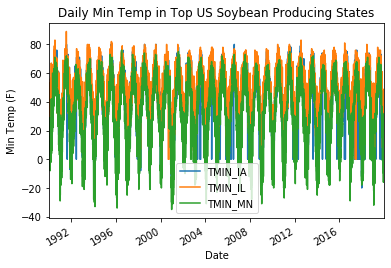

In [11]:
data.drop(columns = ['IA_PRCP', 'IL_PRCP', 'MN_PRCP', 'TMAX_IA', 'TMAX_IL', 'TMAX_MN', 'Settlement Price']).plot() 
plt.xlabel('Date')
plt.ylabel('Min Temp (F)')
plt.title('Daily Min Temp in Top US Soybean Producing States');

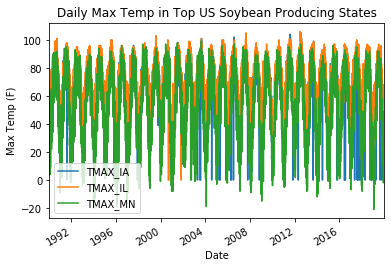

In [34]:
data.drop(columns = ['IA_PRCP', 'IL_PRCP', 'MN_PRCP', 'TMIN_IA', 'TMIN_IL', 'TMIN_MN', 'Settlement Price']).plot() 
plt.xlabel('Date')
plt.ylabel('Max Temp (F)')
plt.title('Daily Max Temp in Top US Soybean Producing States');

## Preprocessing
### Settlement Price

Looking at the smothing effects of the monthly, quarterly, and annual rolling means compared to the actual daily average soybean price in a line plot of monthly, quarterly, and annual rolling means.

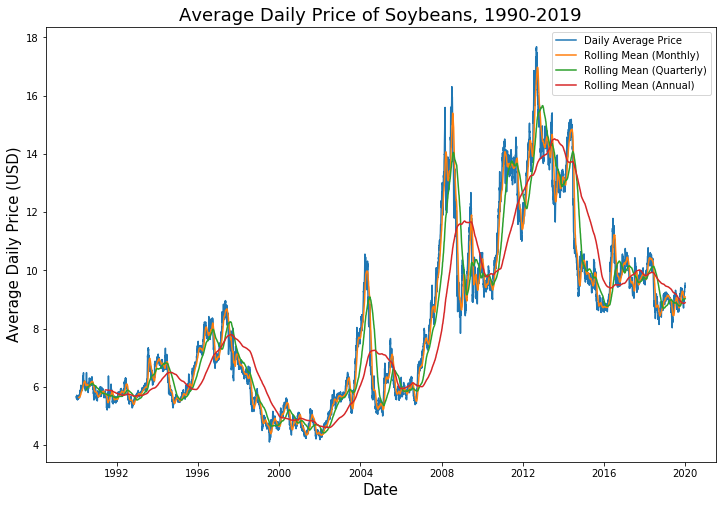

In [73]:
plt.figure(figsize=(12, 8))
plt.plot(data['Settlement Price'], label='Daily Average Price')
plt.plot(data['Settlement Price'].rolling(30).mean(), label='Rolling Mean (Monthly)')
plt.plot(data['Settlement Price'].rolling(120).mean(), label='Rolling Mean (Quarterly)')
plt.plot(data['Settlement Price'].rolling(365).mean(), label='Rolling Mean (Annual)')
plt.legend()
plt.ylabel('Average Daily Price (USD)', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.title('Average Daily Price of Soybeans, 1990-2019', fontsize = 18);
plt.savefig('../Images/AvDailyPriceRolling.png')

The quarterly and annual rolling means appear to do a good job smoothing out the randomness in the data, confirming that we should include a moving average component in our data.

Plotting the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

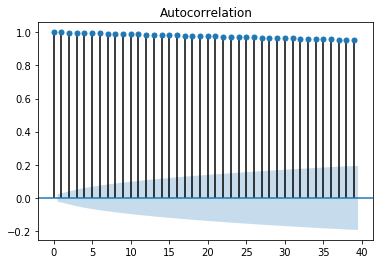

In [38]:
plot_acf(data['Settlement Price']);

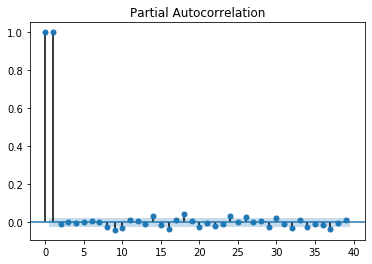

In [40]:
plot_pacf(data['Settlement Price']);

Based on the ACF plot, the data doesn't appear to be stationary.  Since this is an assumption of the Autoregressive Integrated Moving Average (ARIMA) model, let's check the stationarity of the data using an Augmented Dickey-Fuller Test.  

#### Augmented Dickey-Fuller Test
Using $\alpha$ = 0.05, I will perform the following hypothesis test:  
$H_0$= not stationary  
$H_A$ = stationary

In [42]:
# Dickey-Fuller Test
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [43]:
interpret_dftest(adfuller(data['Settlement Price']))

Test Statistic   -2.26793
p-value           0.18252
dtype: float64

Since $\alpha$ < p-value = 0.18, we cannot reject the null hypothesis. So, I will take the difference and perform the test again.

In [44]:
interpret_dftest(adfuller(data['Settlement Price'].diff(1).dropna()))

Test Statistic   -1.363389e+01
p-value           1.702822e-25
dtype: float64

Since $\alpha$ > p-value, we can reject the null hypothesis and accept the alternative hypothesis that the data is stationary. We can now model our time series data by setting the difference hyperparameter to 1.
  
Let's look at the ACF/ PACF plots using the differenced data to visualize the lags that will likely be influencial when modeling the price.

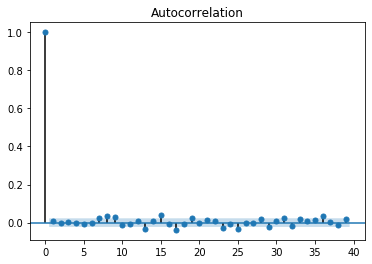

In [45]:
plot_acf(data['Settlement Price'].diff().dropna());

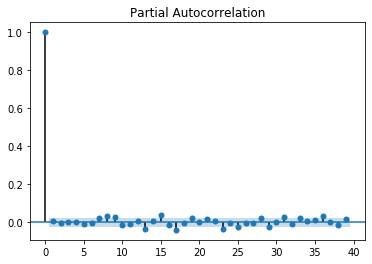

In [47]:
plot_pacf(data['Settlement Price'].diff().dropna());

### Exogenous Features

Shifting the time periods of the weather features by 1, as the model can only forecast based on the information it knows.  For instance, on a given day, the model will only have information regarding the prior day and not the current day, as the current day hasn't happened yet.

In [64]:
data['IA_prcp_lag_1'] = data['IA_PRCP'].shift(1)
data['IL_prcp_lag_1'] = data['IL_PRCP'].shift(1)
data['MN_prcp_lag_1'] = data['MN_PRCP'].shift(1)
data['IA_TMIN_lag_1'] = data['TMIN_IA'].shift(1)
data['IL_TMIN_lag_1'] = data['TMIN_IL'].shift(1)
data['MN_TMIN_lag_1'] = data['TMIN_MN'].shift(1)
data['IA_TMAX_lag_1'] = data['TMAX_IA'].shift(1)
data['IL_TMAX_lag_1'] = data['TMAX_IL'].shift(1)
data['MN_TMAX_lag_1'] = data['TMAX_MN'].shift(1)

Shifting time periods of the weather features to analyze whether prior instances of precipitation and min/max temperatures affect the price of soybeans. Based on domain knowledge, we know that the planting and harvesting seasons last for approximately 2.5 months each; therefore we will investigate whether this lag or lagging by a full year might be informative to our model.

In [65]:
data['IA_prcp_lag_72'] = data['IA_PRCP'].shift(72)
data['IL_prcp_lag_72'] = data['IL_PRCP'].shift(72)
data['MN_prcp_lag_72'] = data['MN_PRCP'].shift(72)
data['IA_prcp_lag_360'] = data['IA_PRCP'].shift(360)
data['IL_prcp_lag_360'] = data['IL_PRCP'].shift(360)
data['MN_prcp_lag_360'] = data['MN_PRCP'].shift(360)

data['IA_TMIN_lag_72'] = data['TMIN_IA'].shift(72)
data['IL_TMIN_lag_72'] = data['TMIN_IL'].shift(72)
data['MN_TMIN_lag_72'] = data['TMIN_MN'].shift(72)
data['IA_TMIN_lag_360'] = data['TMIN_IA'].shift(360)
data['IL_TMIN_lag_360'] = data['TMIN_IL'].shift(360)
data['MN_TMIN_lag_360'] = data['TMIN_MN'].shift(360)

data['IA_TMAX_lag_72'] = data['TMAX_IA'].shift(72)
data['IL_TMAX_lag_72'] = data['TMAX_IL'].shift(72)
data['MN_TMAX_lag_72'] = data['TMAX_MN'].shift(72)
data['IA_TMAX_lag_360'] = data['TMAX_IA'].shift(360)
data['IL_TMAX_lag_360'] = data['TMAX_IL'].shift(360)
data['MN_TMAX_lag_360'] = data['TMAX_MN'].shift(360)


Looking at correlations between lagged features and the settlement price to determine which exogenous features will have the largest predictive capability.

In [67]:
data.drop(columns = ['IA_PRCP', 'IL_PRCP', 'MN_PRCP', 'TMAX_IA', 'TMAX_IL', 'TMAX_MN',
       'TMIN_IA', 'TMIN_IL', 'TMIN_MN']).corr()['Settlement Price'].sort_values(ascending = False)

Settlement Price    1.000000
IL_TMAX_lag_1       0.037513
IL_prcp_lag_1       0.015390
IL_TMIN_lag_1       0.014736
IL_TMAX_lag_360     0.007268
IA_TMAX_lag_1       0.006589
IL_prcp_lag_72      0.006574
IA_prcp_lag_1       0.003846
MN_prcp_lag_1       0.000097
IL_prcp_lag_360    -0.001280
IA_prcp_lag_360    -0.008073
IA_TMIN_lag_1      -0.008096
MN_TMAX_lag_1      -0.009163
MN_prcp_lag_72     -0.009977
IA_prcp_lag_72     -0.010284
MN_prcp_lag_360    -0.013901
IL_TMIN_lag_360    -0.014379
MN_TMIN_lag_1      -0.015075
IL_TMAX_lag_72     -0.022358
IA_TMAX_lag_360    -0.023780
IA_TMIN_lag_360    -0.031398
MN_TMIN_lag_360    -0.042941
MN_TMAX_lag_360    -0.043267
IL_TMIN_lag_72     -0.049870
IA_TMAX_lag_72     -0.058638
IA_TMIN_lag_72     -0.073205
MN_TMAX_lag_72     -0.075090
MN_TMIN_lag_72     -0.083191
Name: Settlement Price, dtype: float64

Seasonal min/ max temperture lags (72 days) seem to be the best predictors, and so I will just keep these for my exogenous features.

In [69]:
data.columns

Index(['IA_PRCP', 'IL_PRCP', 'MN_PRCP', 'TMAX_IA', 'TMAX_IL', 'TMAX_MN',
       'TMIN_IA', 'TMIN_IL', 'TMIN_MN', 'Settlement Price', 'IA_prcp_lag_1',
       'IL_prcp_lag_1', 'MN_prcp_lag_1', 'IA_TMIN_lag_1', 'IL_TMIN_lag_1',
       'MN_TMIN_lag_1', 'IA_TMAX_lag_1', 'IL_TMAX_lag_1', 'MN_TMAX_lag_1',
       'IA_prcp_lag_72', 'IL_prcp_lag_72', 'MN_prcp_lag_72', 'IA_prcp_lag_360',
       'IL_prcp_lag_360', 'MN_prcp_lag_360', 'IA_TMIN_lag_72',
       'IL_TMIN_lag_72', 'MN_TMIN_lag_72', 'IA_TMIN_lag_360',
       'IL_TMIN_lag_360', 'MN_TMIN_lag_360', 'IA_TMAX_lag_72',
       'IL_TMAX_lag_72', 'MN_TMAX_lag_72', 'IA_TMAX_lag_360',
       'IL_TMAX_lag_360', 'MN_TMAX_lag_360'],
      dtype='object')

In [71]:
data.drop(columns = ['IA_PRCP', 'IL_PRCP', 'MN_PRCP', 'TMAX_IA', 'TMAX_IL', 'TMAX_MN',
       'TMIN_IA', 'TMIN_IL', 'TMIN_MN', 'IA_prcp_lag_1',
       'IL_prcp_lag_1', 'MN_prcp_lag_1', 'IA_TMIN_lag_1', 'IL_TMIN_lag_1',
       'MN_TMIN_lag_1', 'IA_TMAX_lag_1', 'IL_TMAX_lag_1', 'MN_TMAX_lag_1',
       'IA_prcp_lag_72', 'IL_prcp_lag_72', 'MN_prcp_lag_72', 'IA_prcp_lag_360',
       'IL_prcp_lag_360', 'MN_prcp_lag_360', 'IA_TMIN_lag_360',
       'IL_TMIN_lag_360', 'MN_TMIN_lag_360', 'IA_TMAX_lag_360',
       'IL_TMAX_lag_360', 'MN_TMAX_lag_360'], inplace = True)

In [72]:
data.to_csv('../data/data_concat_clean.csv')